# Holecards Distribution Assessment

The data used in this project is taken from real money tournaments. For my poker database I use PokerTracker4, which leverages PostgreSQL. For your specific environment adjust the config.txt file to match the database name, user, host, and password. Most likely the only difference will be your database name which is the first line in the config file. I am providing the data in this repo to enable reproducibility for those without a poker database.

### Objectives:
1. Connect to a PostgresSQL database and retrieve data
2. Clean the data in order to view the holecards in a matrix format
3. Observe the distribution of cards dealt from online play

### 1.) Connect to PostgreSQL database and retrieve data 
- We need to generate a connection string for connecting to the database. In general, for security purposes you wouldn't expose your database credentials so to emulate this for this example we're reading in data from a config file instead of hardcoding the connection string into the code. In practice the config.txt file would not be a part of the repository.

### We'll be using the pandas, numpy, and psycopg2 libraries

In [53]:
import numpy as np
import pandas as pd
import psycopg2 as pg

In [3]:
def get_connection_str(config_file):
    '''read each line from config file into a list'''
    config = [line.rstrip('\n') for line in open(config_file)]
    '''save config entries as variables'''
    dbname, user, host, password = config[0], config[1], config[2], config[3]
    '''create database connection string from variables'''
    conn_str = f'dbname={dbname} user={user} host={host} password={password}'
    return conn_str

get_connection_str('config.txt')

'dbname=Bovada user=postgres host=localhost password=dbpass'

### Now we can connect to the database, execute our query, and save the results

In [6]:
def save_data(query_file, title, config_file='config.txt'):
    '''connect to database and execute query'''
    conn_str = get_connection_str(config_file)
    conn = pg.connect(conn_str)
    cur = conn.cursor()
    with open(query_file) as file:
        query = file.read()
    cur.execute(query)
    cols = [desc[0] for desc in cur.description]
    '''transform query results into a pandas df'''
    df = pd.DataFrame(cur.fetchall(), columns=cols)
    df.to_csv(f'data/{title}.csv', encoding='utf-8', index=False)
    cur.close()
    return

save_data('p_cards_query.txt', 'p_cards')

### Let's inspect the data which was saved to data/p_cards.csv

In [7]:
df = pd.read_csv('data/p_cards.csv')
df.head()

,id_hand,card1,card1_suit,card2,card2_suit
0,248095,J,s,T,s
1,248095,Q,d,Q,c
2,248094,T,h,2,d
3,248094,K,c,3,d
4,248093,Q,s,Q,c


### 960,751 rows, and 5 columns

In [9]:
df.shape

(960751, 5)

In [34]:
df.columns

Index(['id_hand', 'card1', 'card1_suit', 'card2', 'card2_suit'], dtype='object')

In [12]:
df.card1.value_counts()

A    142703
K    132291
Q    120687
J    108753
T     96861
9     85588
8     73969
7     62292
6     50843
5     39081
4     27217
3     16065
2      4401
Name: card1, dtype: int64

In [13]:
df.card2.value_counts()

2    143384
3    132049
4    120253
5    108333
6     96667
7     85425
8     73950
9     62375
T     50852
J     39363
Q     27696
K     16027
A      4377
Name: card2, dtype: int64

### By convention PT4 sets the field card1 as the higher ranking card. This explains why the distribution of card1 is proportionally inverted to the distribution of card 2. Adding the distributions together we get the full picture of all cards dealt.

In [22]:
cards_dealt = (df.card1.value_counts() + df.card2.value_counts()).sort_values(ascending=False)
cards_dealt

Q    148383
K    148318
J    148116
3    148114
9    147963
8    147919
2    147785
7    147717
T    147713
6    147510
4    147470
5    147414
A    147080
dtype: int64

In [29]:
cards_dealt.sum()

1921502

In [25]:
descr = cards_dealt.describe()
descr

count        13.000000
mean     147807.846154
std         378.778045
min      147080.000000
25%      147510.000000
50%      147785.000000
75%      148114.000000
max      148383.000000
dtype: float64

### 1,303 more queens were dealt than aces over our sample size of 1,921,502 cards dealt

In [31]:
cards_dealt.iloc[0] - cards_dealt.iloc[-1]

1303

In [32]:
cards_dealt['Q'] - cards_dealt['A']

1303

In [66]:
descr['max'] - descr['min']

1303.0

### 2.) We'd like to be able to visualize all possible 2-card starting hands in a matrix but first we need to clean the data a bit. Here is an example of a NLHE hand matrix where green represents offsuit hands, the blue represents pairs, and the yellow represents suited hands.

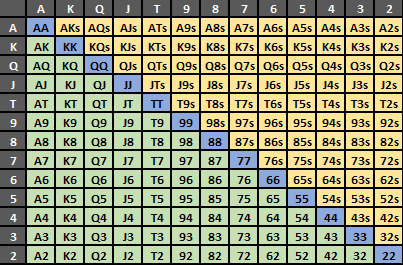

In [69]:
from IPython import display
display.Image('https://i.gyazo.com/514a795500080ced4ba6cc1c82248371.png')

In [30]:
def hand_to_matrix_format(df):
    '''
    Convert as follows to enable displaying hands in a matrix:
        suited hands: AsKs to AK,
        offsuit hands: AsKh to KA,
        paired hands: 9h9c to 99
    '''
    card1_ls = []
    card2_ls = []
    for i, suit in enumerate(df.card1_suit):
        card1 = ''
        card2 = ''
        if suit:
            if suit != df.card2_suit.iloc[i]:
                card1 = str(df.card2.iloc[i])
                card2 = str(df.card1.iloc[i])
            else:
                card1 = str(df.card1.iloc[i])
                card2 = str(df.card2.iloc[i])
        card1_ls.append(card1)
        card2_ls.append(card2)
    return card1_ls, card2_ls

### The ranking of our cards needs to be preserved so let's set the matrix enabled columns to Categorical types and state that the order matters

In [2]:
CARDS = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']

In [63]:
def clean_data(file):
    df = pd.read_csv(file)
    df['c1'], df['c2'] = hand_to_matrix_format(df)
    df.c1 = pd.Categorical(df.c1, ordered=True, categories=CARDS)
    df.c2 = pd.Categorical(df.c2, ordered=True, categories=CARDS)
    return df

### Now let's redefine our dataframe to be the cleaned version of our data. Looking at the first five rows, we can verify that JsTs is represented correctly as JT and Th2d is represented correctly as 2T in our c1 and c2 columns.

In [42]:
df = clean_data('data/p_cards.csv')
df.head()

,id_hand,card1,card1_suit,card2,card2_suit,c1,c2
0,248095,J,s,T,s,J,T
1,248095,Q,d,Q,c,Q,Q
2,248094,T,h,2,d,2,T
3,248094,K,c,3,d,3,K
4,248093,Q,s,Q,c,Q,Q


### 3.) Now we can group-by our matrix friendly columns c1 and c2 and count how many specific hands were dealt to all players. The diagonal from top left to bottom right are the paired hands. All hands below the diagonal are offsuit holdings, and suited holdings are above the diagonal.

- As Ks = (A, K)
- Ts 8d = (8, T)
- 7d 6d = (7, 6)

### AA was dealt 4,377 times, AKo was dealt 8,734 times, and AKs was dealt 2,906 times

In [57]:
hand_matrix = df.groupby(['c1','c2']).id_hand.agg(['count']).unstack()
hand_matrix

count                                                                    \
c2     A     K     Q     J     T     9     8     7     6     5     4     3   
c1                                                                           
A   4377  2906  2997  2875  2941  2840  2878  2813  2832  2896  2860  2936   
K   8734  4387  2888  2919  2973  2958  2939  2781  2894  3027  2955  2954   
Q   8661  8766  4384  2915  2991  2931  2840  2932  2867  2842  2935  2836   
J   8627  8787  8831  4409  2887  2922  2889  2846  2888  2926  2825  2939   
T   8695  8637  8652  8721  4355  2881  2942  2896  2884  2923  2889  2973   
9   8612  8647  8821  8683  8618  4462  2900  2885  2897  2880  2956  2863   
8   8517  8851  8763  8587  8756  8659  4429  2896  2927  2888  2888  2827   
7   8740  8750  8605  8680  8835  8800  8638  4328  2801  2884  2974  2939   
6   8735  8602  8848  8744  8653  8565  8697  8580  4253  2890  2831  2888   
5   8585  8568  8681  8524  8588  8804  8760  8626  8705  4336  2912  2862   
4   8566  8709  8732  8718  8702  8700  8665  8793  8726  8664  4253  2911   
3   8701  8769  8807  8736  8528  8634  8767  8720  8866  8687  8586  4320   
2   8512  8669  8582  8819  8555  8700  8728  8685  8763  8726  8525  8841   

          
c2     2  
c1        
A   2867  
K   2861  
Q   2892  
J   3010  
T   2883  
9   2883  
8   2859  
7   2962  
6   2921  
5   2894  
4   2942  
3   2904  
2   4401

### When we normalize the data we can get a sense of the occurrence percentage of each holding and compare it to its expected occurrence percentage.

- Total possible preflop combinations 1,326
- For a given suited hand there are 4 possible combinations
- For a given paired hand there are 6 possible combinations
- For a given offsuit hand there are 12 possible combinations

### Expected percent occurrence

- suited: 0.3017 %
- paired: 0.4525 %
- offsuit: 0.9050 %


In [65]:
hand_matrix_percent = hand_matrix / df.shape[0] * 100.0
np.round(hand_matrix_percent, decimals=3)

count                                                                 \
c2      A      K      Q      J      T      9      8      7      6      5   
c1                                                                         
A   0.456  0.302  0.312  0.299  0.306  0.296  0.300  0.293  0.295  0.301   
K   0.909  0.457  0.301  0.304  0.309  0.308  0.306  0.289  0.301  0.315   
Q   0.901  0.912  0.456  0.303  0.311  0.305  0.296  0.305  0.298  0.296   
J   0.898  0.915  0.919  0.459  0.300  0.304  0.301  0.296  0.301  0.305   
T   0.905  0.899  0.901  0.908  0.453  0.300  0.306  0.301  0.300  0.304   
9   0.896  0.900  0.918  0.904  0.897  0.464  0.302  0.300  0.302  0.300   
8   0.886  0.921  0.912  0.894  0.911  0.901  0.461  0.301  0.305  0.301   
7   0.910  0.911  0.896  0.903  0.920  0.916  0.899  0.450  0.292  0.300   
6   0.909  0.895  0.921  0.910  0.901  0.891  0.905  0.893  0.443  0.301   
5   0.894  0.892  0.904  0.887  0.894  0.916  0.912  0.898  0.906  0.451   
4   0.892  0.906  0.909  0.907  0.906  0.906  0.902  0.915  0.908  0.902   
3   0.906  0.913  0.917  0.909  0.888  0.899  0.913  0.908  0.923  0.904   
2   0.886  0.902  0.893  0.918  0.890  0.906  0.908  0.904  0.912  0.908   

                         
c2      4      3      2  
c1                       
A   0.298  0.306  0.298  
K   0.308  0.307  0.298  
Q   0.305  0.295  0.301  
J   0.294  0.306  0.313  
T   0.301  0.309  0.300  
9   0.308  0.298  0.300  
8   0.301  0.294  0.298  
7   0.310  0.306  0.308  
6   0.295  0.301  0.304  
5   0.303  0.298  0.301  
4   0.443  0.303  0.306  
3   0.894  0.450  0.302  
2   0.887  0.920  0.458